# Functions and Data Processing

In [5]:
# Copyright (C) 2021-2022 Katherine Xie - All Rights Reserved.

# Generates figures to display results of my research
# Author: Katherine Xie
# Version 2.0 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from numpy import random
import pickle
import scipy.stats as st
import itertools 
import seaborn as sns

# Filters dataframe based on neuron type. 
# Establishes a synapse threshold of greater than 1
# data - the dataframe
# col_substr - regex to select for substrings that represent neuron type in columns
# row_substr - regex to select for substrings that represent neuron type in rows
# row_header - header for indices
def filter_neuron_types(data, col_substr, row_substr, idx_header):
    first_column = df.iloc[:, 0] # gets first column to use as row indices
    # columns
    new_df = data.filter(regex=col_substr, axis='columns') 
    
    # rows
    new_df.insert(0, idx_header, first_column, True) # inserts column with row labels into the new dataframe
    new_df.set_index(idx_header, inplace=True) # sets inserted column as dataframe indicies
    new_df = new_df.filter(regex=row_substr, axis='index')
    
    # establishing a threshold of num synapses > 1 to count as a connection
    num_rows = len(new_df)
    # loops thru rows of new_df
    for i in range(num_rows):
        row = new_df.iloc[i] # gets row
        new_row = np.where(row == 1, 0, row) # if synaspse num = 1, change to 0
        new_df.iloc[i] = new_row
    
    return new_df

# Normalizes weights by column's sum in a pandas df
# df - dataframe
# sum_of_w - the sum of the weights
def normalize_weights_df(df, sum_of_w):
    col = len(df.columns)
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = df.iloc[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            df.iloc[:,c] = [i/s for i in w]
    return sum_of_w * df

# Normalizes weights by column's sum in a numpy array
# arr - numpy array
# sum_of_w - the sum of the weights
def normalize_weights_np(arr, sum_of_w):
    col = len(arr[0])
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = arr[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            arr[:,c] = [i/s for i in w]
    return sum_of_w * arr

# get the number kc from string arr
# a - num kcs removed
def get_num_kc(string, a):
    nums = np.zeros(a)
    for i in range(a):
        end = False
        s = string[i]
        j = 1
        num_str = ""
        while end == False:
            # end loop if space is reached
            if s[-j] == " ": 
                end = True
            else:
                num_str = s[-j] + num_str
            j += 1
        nums[i] = int(num_str)
    return nums

# mbon - index of mbon
def count_num_removed(kc_mbon, nums, mbon):
    count = 0
    nums = nums.astype(int)
    for i in range(len(nums)):
        if kc_mbon.iloc[nums[i], mbon] != 0:
            count += 1
    return count


df = pd.read_csv('connectivity matrix table 1.csv') # matrix of connections between neurons

# FILTER DATA FOR PNs (rows) to KCs (columns) CONNECTIONS -> pn_kc
pn_kc = filter_neuron_types(df, "(?=.*KC)(?=.*right)", "(?=.*PN)(?=.*right)", "Presynaptic PNs") # filter w/ regex PNs and KCs

# normalize weights
pn_kc = normalize_weights_df(pn_kc, 1)

# FILTER DATA FOR KCs TO MBONs CONNECTIONS -> kc_to_mbon
kc_mbon = filter_neuron_types(df, "(?=.*MBON)(?=.*right)", "(?=.*KC)(?=.*right)", "Presynaptic KCs") # filter w/ regex for KCs and MBON lefts

# take out MBONs with no KC connections
kc_mbon = kc_mbon.drop(kc_mbon.loc[:, (kc_mbon.sum(axis=0) == 0)], axis=1)

# adding a fictional MBON
fict_weights = np.full(len(kc_mbon), 0.1) # initializing all weights at 0.1
kc_mbon['MBON-fict'] = fict_weights

# normalizing weights
kc_mbon = normalize_weights_df(kc_mbon, 1)
kc_mbon = kc_mbon.fillna(0)

# Set numbers
num_kcs = len(pn_kc.columns)
num_pns = len(pn_kc) # number of PNs (40), also = number of dimensions of the odor
num_mbons = len(kc_mbon.columns)
R = 20 # number of realizations of training
K = 24 # number of KC removal sets
T = 5000 # number of time steps

# color palette (19 colors)
colors = ['steelblue', 'darkorange', 'forestgreen', 'crimson', 'mediumpurple', 'rosybrown', 
          'pink', 'goldenrod', 'darkturquoise', 'thistle', 'lightsteelblue', 'peachpuff', 
          'lightgreen', 'lightsalmon', 'sienna', 'orchid', 'gray', 'khaki', 'lightblue']

In [2]:
print("pn_kc shape:", pn_kc.shape)
print("kc_mbon shape:", kc_mbon.shape)
kc_mbon

pn_kc shape: (44, 113)
kc_mbon shape: (113, 16)


,MBON-a1 right,MBON-a2 right,MBON-b1 right,MBON-b2 right,MBON-c1 right,MBON-d1 right,MBON-e1 right,MBON-e2 right,MBON-g1 right,MBON-g2 right,MBON-h1 right,MBON-h2 right,MBON-i1 right,MBON-j1 right,MBON-k1 right,MBON-fict
Presynaptic KCs,,,,,,,,,,,,,,,,
1 claw KC right,0.006579,0.014205,0.032828,0.026525,0.025964,0.032333,0.025097,0.025210,0.006865,0.008493,0.032164,0.032164,0.000000,0.079545,0.0,0.00885
1 claw KC right,0.026316,0.011364,0.060606,0.042440,0.028932,0.032333,0.036680,0.042017,0.022883,0.021231,0.026316,0.017544,0.088889,0.022727,0.0,0.00885
1 claw KC right,0.016447,0.005682,0.025253,0.034483,0.029674,0.030023,0.032819,0.000000,0.006865,0.008493,0.017544,0.017544,0.022222,0.022727,0.0,0.00885
1 claw KC right,0.000000,0.000000,0.015152,0.005305,0.028190,0.034642,0.023166,0.042017,0.009153,0.008493,0.014620,0.023392,0.033333,0.022727,0.0,0.00885
1 claw KC right,0.006579,0.025568,0.030303,0.023873,0.021513,0.016166,0.003861,0.042017,0.020595,0.023355,0.017544,0.026316,0.022222,0.034091,0.0,0.00885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
young KC right,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00885
young KC right,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00885
young KC right,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00885


# Figure 1 - Foundations of the Model

Text(0, 0.5, 'Projection Neuron 2')

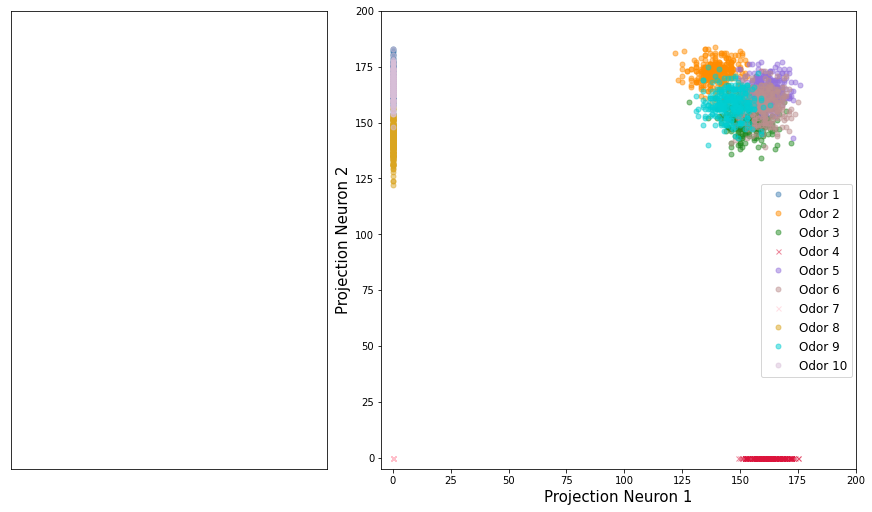

In [6]:
fig = plt.figure(figsize=(12,7), constrained_layout=True)
gs = fig.add_gridspec(1, 5, wspace=5)

# 1A MODEL APPROXIMATION
f_ax1 = fig.add_subplot(gs[:, 0:2])

# remove x and y ticks
# x axis
f_ax1.set_xticklabels([])
f_ax1.set_xticks([])

# y axis
f_ax1.set_yticklabels([])
f_ax1.set_yticks([])


# 1B DISTRIBUTION OF PN ACTIVITY
f_ax2 = fig.add_subplot(gs[:, 2:5])

N = 10
num_pns = 44
num_inputs = 50000
spikes = 200

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control2/input-means1.pkl', 'rb') as f:
    input_means = pickle.load(f)
    
response = input_means

bool_response = np.where(input_means > 0, 1, 0) # boolean version of response (1=fire, 0=no fire)

all_inputs = np.zeros((num_inputs, num_pns))
odor_idx = num_inputs//N
pn_inputs = np.zeros((N, num_inputs//N, num_pns))
for n in range(N):
    inputs = np.random.binomial(spikes, response[n], size=(num_inputs//N, num_pns))
    all_inputs[n*odor_idx:odor_idx*(n + 1)] = inputs
    pn_inputs[n] = inputs

categories = ['o', 'o', 'o', 'x', 'o', 'o', 'x', 'o', 'o', 'o'] # firing pattern for 10 odors
labels = []
for i in range(N):
    labels.append("Odor {}".format(i+1))

# plotting
for i in range(N):
    # 22, 23 - 10 odors
    # 9, 10 - 3 odors
    f_ax2.plot(pn_inputs[i, 0:300, 22], pn_inputs[i, 0:300, 23], marker = categories[i], markersize=5, alpha = 0.5,
             label = labels[i], linestyle = '', color = colors[i])
f_ax2.set_xlim(-5, 200)
f_ax2.set_ylim(-5, 200)
f_ax2.legend(loc=(0.8,0.2), prop={'size': 12})
f_ax2.set_xlabel('Projection Neuron 1', fontsize=15)
f_ax2.set_ylabel('Projection Neuron 2', fontsize=15)

# Figure 2 - Control Results

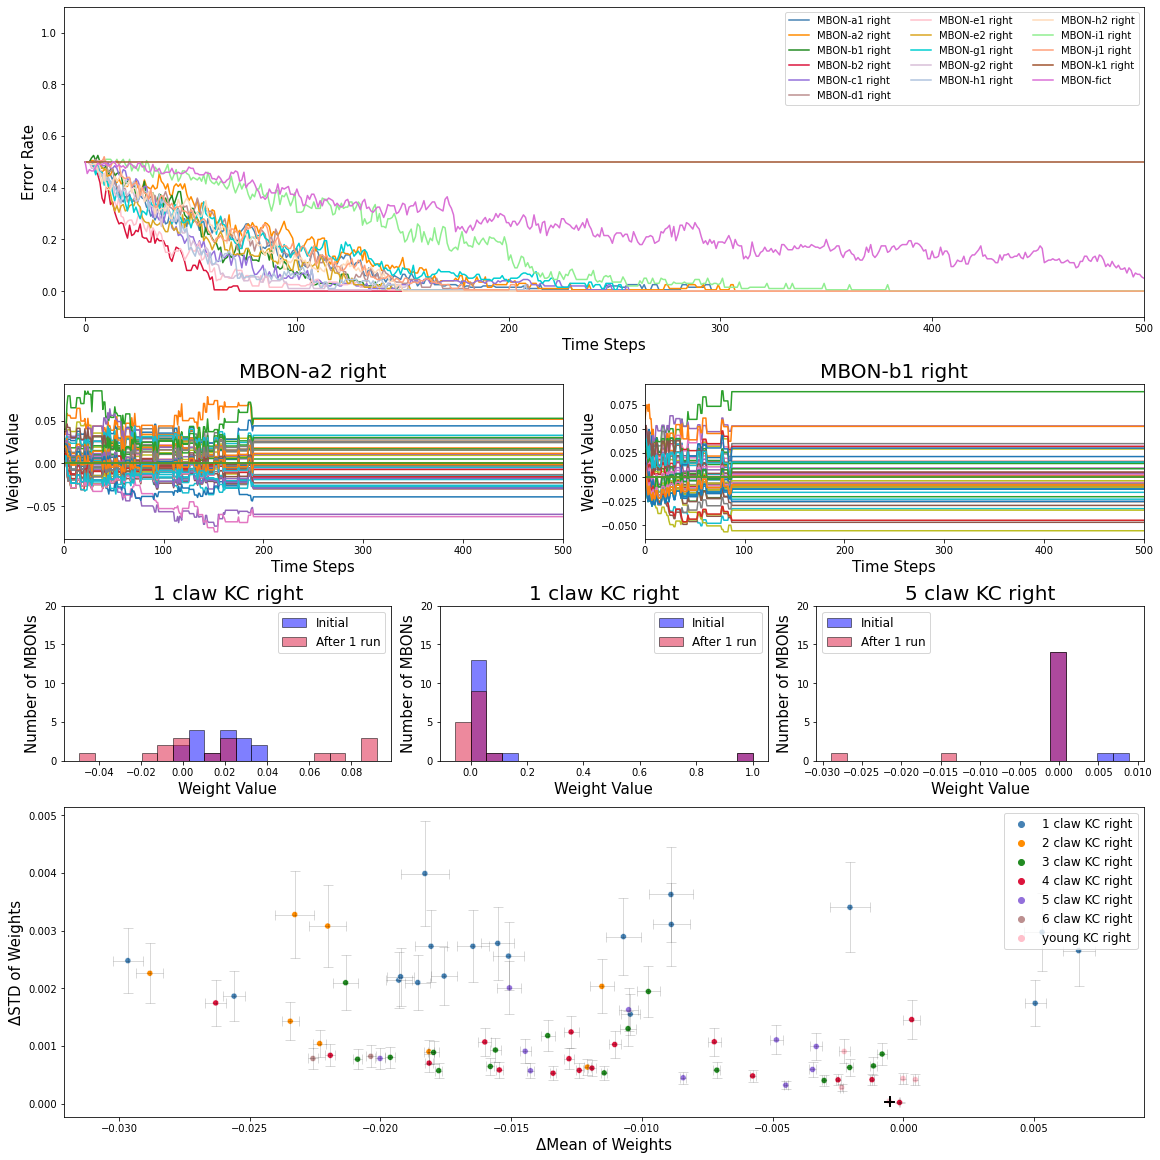

In [4]:
axis_fontsize = 15
title_fontsize = 20
fig2 = plt.figure(figsize=(16,16), constrained_layout=True)
gs2 = fig2.add_gridspec(ncols=6, nrows=6)

# 2A AVERAGE ERROR OVER TIME
f2_ax1 = fig2.add_subplot(gs2[0:2, :])

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control2/all-error-rates1.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # R, T, num_mbons

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control3/all-error-rates1.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f)

# concatenate arrays from both runs
error_rate_over_time = np.concatenate((error_over_time1, error_over_time2), axis = 0)

avg_error = np.mean(error_rate_over_time, axis=0)

x = np.linspace(0, 5000, 5000)
for i in range(num_mbons):
    f2_ax1.plot(x, avg_error[:,i], label = kc_mbon.columns[i], color = colors[i])
    
f2_ax1.legend(fontsize=10, loc=1, ncol = 3)
f2_ax1.set_ylim(-0.1, 1.1)
f2_ax1.set_xlim(-10, 500)
f2_ax1.set_xlabel("Time Steps", fontsize=axis_fontsize)
f2_ax1.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 2B WEIGHTS OVER TIME ACROSS KCS FOR MBON-a2 left
f2_ax2 = fig2.add_subplot(gs2[2, 0:3])

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control2/total-weights1.pkl', 'rb') as f:
    weights_over_time1 = pickle.load(f) # R, T, num_kcs, num_mbons

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control3/total-weights1.pkl', 'rb') as f:
    weights_over_time2 = pickle.load(f) 

# concatenate arrays from both runs
weights_over_time = np.concatenate((weights_over_time1, weights_over_time2), axis = 0)
    
x = np.linspace(0, 5000, 5000)

for k in range(num_kcs):
    f2_ax2.plot(x, weights_over_time[0, :, k, 1]) # plot weights over time for MBON-a2 left (index=1)
f2_ax2.set_title("{}".format(kc_mbon.columns[1]), fontsize=title_fontsize)
f2_ax2.set_xlim(0, 500)
f2_ax2.set_xlabel("Time Steps", fontsize=axis_fontsize)
f2_ax2.set_ylabel("Weight Value", fontsize=axis_fontsize)

# 2C WEIGHTS OVER TIME ACROSS KCS FOR MBON-b1 left
f2_ax3 = fig2.add_subplot(gs2[2, 3:])

x = np.linspace(0, 5000, 5000)

for k in range(num_kcs):
    f2_ax3.plot(x, weights_over_time[0, :, k, 2]) # plot weights over time for MBON-b1 left (index=2)
f2_ax3.set_title("{}".format(kc_mbon.columns[2]), fontsize=title_fontsize)
f2_ax3.set_xlim(0, 500)
f2_ax3.set_xlabel("Time Steps", fontsize=axis_fontsize)
f2_ax3.set_ylabel("Weight Value", fontsize=axis_fontsize)

# 2D 1 claw KC left (index=2) WEIGHT DISTRIBUTION
f2_ax4 = fig2.add_subplot(gs2[3, 0:2])
    
# average final weights over 10
avg_weights = np.mean(weights_over_time, axis=0)

x = np.zeros((3, num_mbons))
x[0] = kc_mbon.iloc[2]
x[1] = weights_over_time[0, -1, 2] # final weights after realization #1 of training
x[2] = avg_weights[-1, 2]

# initial weights
f2_ax4.hist(x[0], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='blue', alpha=0.5, label='Initial')

# final weights after 1 training run
f2_ax4.hist(x[1], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='crimson', alpha=0.5, label='After 1 run')

f2_ax4.set_title(kc_mbon.index[2], fontsize=title_fontsize)
f2_ax4.set_xlabel('Weight Value', fontsize=axis_fontsize)
f2_ax4.set_ylabel('Number of MBONs', fontsize=axis_fontsize)
f2_ax4.set_ylim(0, 20)
f2_ax4.legend(fontsize=12)

# 2E 2 claw KC left (index=18) WEIGHT DISTRIBUTION
f2_ax5 = fig2.add_subplot(gs2[3, 2:4])

x = np.zeros((3, num_mbons))
x[0] = kc_mbon.iloc[18]
x[1] = weights_over_time[0, -1, 18] # final weights after realization #1 of training
x[2] = avg_weights[-1, 18]

# initial weights
f2_ax5.hist(x[0], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='blue', alpha=0.5, label='Initial')

# final weights after 1 training run
f2_ax5.hist(x[1], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='crimson', alpha=0.5, label='After 1 run')

f2_ax5.set_title(kc_mbon.index[18], fontsize=title_fontsize)
f2_ax5.set_xlabel('Weight Value', fontsize=axis_fontsize)
f2_ax5.set_ylabel('Number of MBONs', fontsize=axis_fontsize)
f2_ax5.set_ylim(0, 20)
f2_ax5.legend(fontsize=12)

# 2F 5 claw KC left (index=67) WEIGHT DISTRIBUTION
f2_ax6 = fig2.add_subplot(gs2[3, 4:])

x = np.zeros((3, num_mbons))
x[0] = kc_mbon.iloc[61]
x[1] = weights_over_time[0, -1, 61] # final weights after realization #1 of training
x[2] = avg_weights[-1, 61]

# initial weights
f2_ax6.hist(x[0], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='blue', alpha=0.5, label='Initial')

# final weights after 1 training run
f2_ax6.hist(x[1], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='crimson', alpha=0.5, label='After 1 run')

f2_ax6.set_title(kc_mbon.index[67], fontsize=title_fontsize)
f2_ax6.set_xlabel('Weight Value', fontsize=axis_fontsize)
f2_ax6.set_ylabel('Number of MBONs', fontsize=axis_fontsize)
f2_ax6.set_ylim(0, 20)
f2_ax6.legend(fontsize=12)

# 2G SCATTER PLOT OF DELTA MEAN & STD OF WEIGHTS
f2_ax7 = fig2.add_subplot(gs2[4:, :])

mean_weights = np.mean(weights_over_time, axis = 3)
std_weights = np.mean(weights_over_time, axis = 3)

# organize into dataframe 
# x axis - difference in means of final and initial KC weights
x = mean_weights[:, -1] - mean_weights[:, 0]

# y axis - difference in stds of final and initial KC weights
y = std_weights[:, -1] - std_weights[:, 0]

# average mean and std across realizations
avg_of_mean_weights = np.mean(x, axis = 0)
avg_of_std_weights = np.std(y, axis = 0)

# create dataframe to organize scatter plot values
names = kc_mbon.index
df = pd.DataFrame({'Type of KC':names, 'Mean':avg_of_mean_weights, 'STD':avg_of_std_weights})

# Set color palette
sns.set_palette(sns.color_palette(colors))

# get sem
sem_m = st.sem(x, axis=0)
sem_s = st.sem(y, axis=0)

# plot scatter plots of std vs mean
f2_ax7.errorbar(x=df['Mean'], y=df['STD'], xerr=sem_m, yerr=sem_s, capsize=5, color='black', alpha=0.15,
                linewidth=1, linestyle='', marker=None)
sns.scatterplot(ax=f2_ax7, x=df['Mean'], y=df['STD'], hue=df['Type of KC'])

# sns.pointplot(x=df['Mean'], y=df['STD'], hue=df['Type of KC'], data=df, join=False)
f2_ax7.set_xlabel('ΔMean of Weights', fontsize=axis_fontsize)
f2_ax7.set_ylabel('ΔSTD of Weights', fontsize=axis_fontsize)
f2_ax7.legend(loc=1, fontsize=12)

In [15]:
bool_syn = np.where(kc_mbon > 0, 1, 0)
sums = np.sum(bool_syn, axis=0)
for m in range(num_mbons):
    print(f"{kc_mbon.columns[m]}: {sums[m]}")
    
print(f"Average: {np.mean(sums[:-1])}")

MBON-a1 right: 54
MBON-a2 right: 63
MBON-b1 right: 52
MBON-b2 right: 44
MBON-c1 right: 58
MBON-d1 right: 55
MBON-e1 right: 57
MBON-e2 right: 27
MBON-g1 right: 63
MBON-g2 right: 61
MBON-h1 right: 57
MBON-h2 right: 55
MBON-i1 right: 27
MBON-j1 right: 26
MBON-k1 right: 1
Average: 46.666666666666664


# Figure 3 - Ablation Cartoon

Text(0.5, 1.0, 'Targeted Ablation')

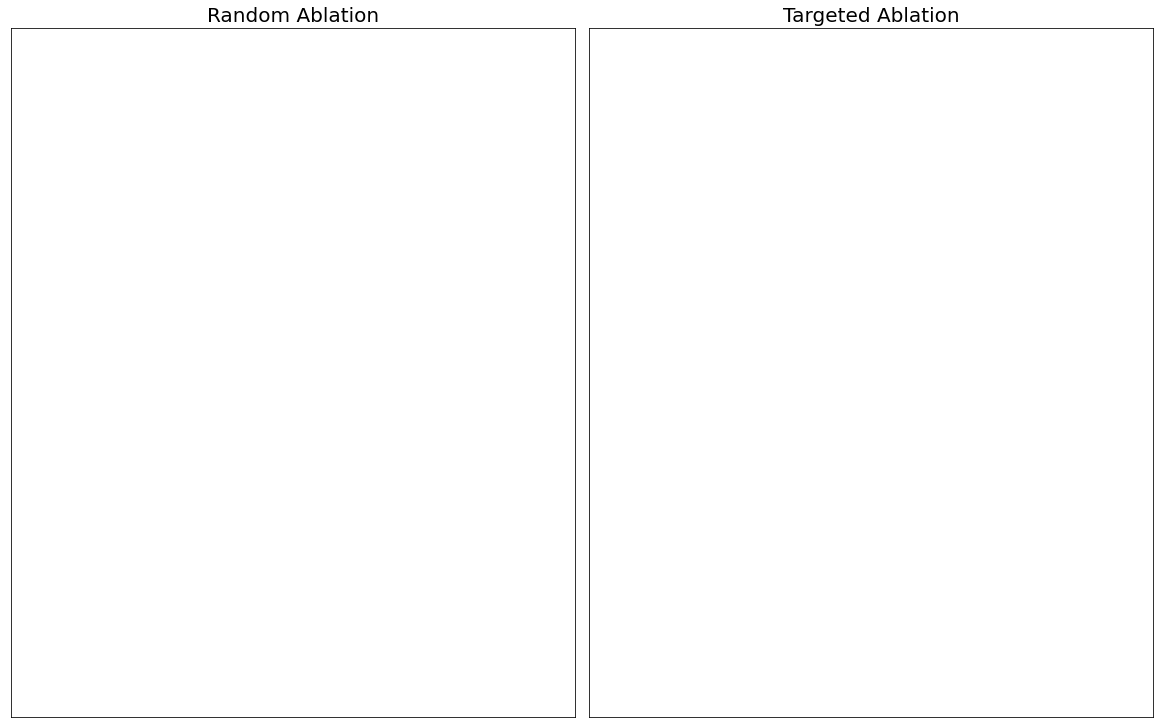

In [33]:
axis_fontsize = 15
title_fontsize = 20
legend_fontsize = 8
fig3 = plt.figure(figsize=(16,10), constrained_layout=True)
gs3 = fig3.add_gridspec(ncols=6, nrows=6)

# 3A CARTOON OF RANDOM ABLATION
f3_ax1 = fig3.add_subplot(gs3[0:6, 0:3])

# remove x and y ticks
# x axis
f3_ax1.set_xticklabels([])
f3_ax1.set_xticks([])

# y axis
f3_ax1.set_yticklabels([])
f3_ax1.set_yticks([])

f3_ax1.set_title("Random Ablation", fontsize=title_fontsize)

# 3B CARTOON OF TARGETED ABLATION
f3_ax2 = fig3.add_subplot(gs3[0:6, 3:])

# remove x and y ticks
# x axis
f3_ax2.set_xticklabels([])
f3_ax2.set_xticks([])

# y axis
f3_ax2.set_yticklabels([])
f3_ax2.set_yticks([])

f3_ax2.set_title("Targeted Ablation", fontsize=title_fontsize)

# Figure 4 - Ablation Results

Text(0, 0.5, 'Average % Ablated per KC Type')

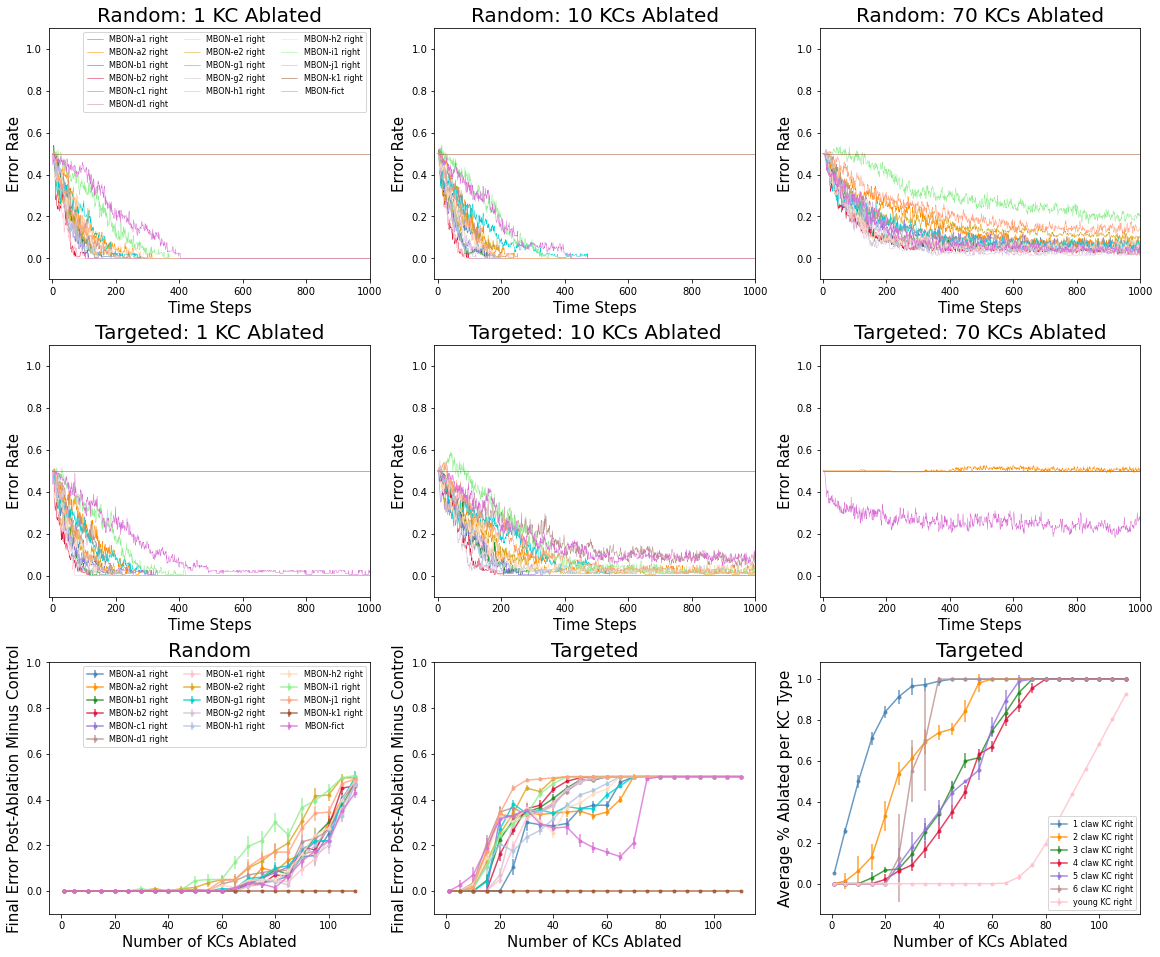

In [9]:
axis_fontsize = 15
title_fontsize = 20
legend_fontsize = 8
fig4 = plt.figure(figsize=(16,30), constrained_layout=True)
gs4 = fig4.add_gridspec(ncols=6, nrows=15)

# 4A ERROR OVER TIME (REMOVED 1) - RANDOM
f4_ax1 = fig4.add_subplot(gs4[6:8, 0:2])

# list of num of KCs removed
num_removed = np.ones(23)
num_removed[1:] = np.linspace(5, 110, 22)
num_removed = num_removed.astype(int)

# import data
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-ablation2/all-error-rates2.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-ablation3/all-error-rates2.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f) 

# concatenate arrays from both runs
r_error_rate_over_time = np.concatenate((error_over_time1, error_over_time2), axis = 1)

avg_error = np.mean(r_error_rate_over_time, axis=1)

x = np.linspace(0, 5000, 5000)

for i in range(num_mbons):
    f4_ax1.plot(x, avg_error[0, : ,i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f4_ax1.set_ylim(-0.1, 1.1)
f4_ax1.set_xlim(-10, 1000)
f4_ax1.legend(fontsize=legend_fontsize, loc=1, ncol=3)
f4_ax1.set_title("Random: {} KC Ablated".format(num_removed[0]), fontsize=title_fontsize)
f4_ax1.set_xlabel("Time Steps", fontsize=axis_fontsize)
f4_ax1.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 4B ERROR OVER TIME (REMOVED 10) - RANDOM
f4_ax2 = fig4.add_subplot(gs4[6:8, 2:4])

for i in range(num_mbons):
    f4_ax2.plot(x, avg_error[2, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f4_ax2.set_ylim(-0.1, 1.1)
f4_ax2.set_xlim(-10, 1000)
f4_ax2.set_title("Random: {} KCs Ablated".format(num_removed[2]), fontsize=title_fontsize)
f4_ax2.set_xlabel("Time Steps", fontsize=axis_fontsize)
f4_ax2.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 4C ERROR OVER TIME (REMOVED 70) - RANDOM
f4_ax3 = fig4.add_subplot(gs4[6:8, 4:])

for i in range(num_mbons):
    f4_ax3.plot(x, avg_error[14, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f4_ax3.set_ylim(-0.1, 1.1)
f4_ax3.set_xlim(-10, 1000)
f4_ax3.set_title("Random: {} KCs Ablated".format(num_removed[14]), fontsize=title_fontsize)
f4_ax3.set_xlabel("Time Steps", fontsize=axis_fontsize)
f4_ax3.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 4D ERROR OVER TIME (REMOVED 1) - TARGETED
f4_ax4 = fig4.add_subplot(gs4[8:10, 0:2])

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-ablation2/all-error-rates3.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-ablation3/all-error-rates3.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f)
    
t_error_rate_over_time = np.concatenate((error_over_time1, error_over_time2), axis = 1)

avg_error = np.mean(t_error_rate_over_time, axis=1)

x = np.linspace(0, 5000, 5000)

for i in range(num_mbons):
    f4_ax4.plot(x, avg_error[0, : ,i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f4_ax4.set_ylim(-0.1, 1.1)
f4_ax4.set_xlim(-10, 1000)
f4_ax4.set_title("Targeted: {} KC Ablated".format(num_removed[0]), fontsize=title_fontsize)
f4_ax4.set_xlabel("Time Steps", fontsize=axis_fontsize)
f4_ax4.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 4E ERROR OVER TIME (REMOVED 10) - TARGETED
f4_ax5 = fig4.add_subplot(gs4[8:10, 2:4])

for i in range(num_mbons):
    f4_ax5.plot(x, avg_error[2, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f4_ax5.set_ylim(-0.1, 1.1)
f4_ax5.set_xlim(-10, 1000)
f4_ax5.set_title("Targeted: {} KCs Ablated".format(num_removed[2]), fontsize=title_fontsize)
f4_ax5.set_xlabel("Time Steps", fontsize=axis_fontsize)
f4_ax5.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 4F ERROR OVER TIME (REMOVED 70) - TARGETED
f4_ax6 = fig4.add_subplot(gs4[8:10, 4:])

for i in range(num_mbons):
    f4_ax6.plot(x, avg_error[14, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f4_ax6.set_ylim(-0.1, 1.1)
f4_ax6.set_xlim(-10, 1000)
f4_ax6.set_title("Targeted: {} KCs Ablated".format(num_removed[14]), fontsize=title_fontsize)
f4_ax6.set_xlabel("Time Steps", fontsize=axis_fontsize)
f4_ax6.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 4G ERROR VS NUM KCS ABLATED - RANDOM
f4_ax7 = fig4.add_subplot(gs4[10:12, 0:2])

# import data
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control2/all-error-rates1.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # R, T, num_mbons

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control3/all-error-rates1.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f)

# concatenate arrays from both runs
error_control = np.concatenate((error_over_time1, error_over_time2), axis = 0)

# x-axis -> number of KCs removed
numbers = np.ones(24)
numbers[1:23] = np.linspace(5, 110, 22)
numbers[23] = 113
numbers = numbers.astype(int).tolist()
x = []       
for i in range(num_mbons):
    for j in range(K):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(r_error_rate_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
for i in range(K):
#     std_y[i] = np.std(r_error_rate_over_time[i], axis=0)
    std_y[i] = st.sem(r_error_rate_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
    f4_ax7.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.8, 
                    label=kc_mbon.columns[p], ms=3, c=colors[p])

f4_ax7.set_xlabel("Number of KCs Ablated", fontsize=axis_fontsize)
f4_ax7.set_ylabel("Final Error Post-Ablation Minus Control", fontsize=axis_fontsize)
f4_ax7.set_ylim(-0.1, 1.0)
f4_ax7.set_title("Random", fontsize=title_fontsize)
f4_ax7.legend(fontsize=legend_fontsize, loc=1, ncol=3)

# 4H ERROR VS NUM KCS ABLATED - TARGETED
f4_ax8 = fig4.add_subplot(gs4[10:12, 2:4])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(t_error_rate_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
for i in range(K):
#     std_y[i] = np.std(t_error_rate_over_time[i], axis=0)
    std_y[i] = st.sem(t_error_rate_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
    f4_ax8.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.8, 
                     label=kc_mbon.columns[p], ms=3, c=colors[p])

f4_ax8.set_xlabel("Number of KCs Ablated", fontsize=axis_fontsize)
f4_ax8.set_ylabel("Final Error Post-Ablation Minus Control", fontsize=axis_fontsize)
f4_ax8.set_ylim(-0.1, 1.0)
f4_ax8.set_title("Targeted", fontsize=title_fontsize)

# 4I PERCENTAGE OF EACH KC TYPE ABLATED VS NUMBER ABLATED
f4_ax9 = fig4.add_subplot(gs4[10:12, 4:6])

# import data
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-ablation2/kcs-removed3.pkl', 'rb') as f:
    kc_names1 = pickle.load(f) # K, R, index of a KC removed

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-ablation3/kcs-removed3.pkl', 'rb') as f:
    kc_names2 = pickle.load(f) # K, R, index of a KC removed

kc_names1 = np.array(kc_names1, dtype='object')
kc_names2 = np.array(kc_names2, dtype='object')

kc_names = np.concatenate((kc_names1, kc_names2), axis = 1)

kc_types = ['1 claw KC right', '2 claw KC right', '3 claw KC right', '4 claw KC right', '5 claw KC right', 
            '6 claw KC right', 'young KC right']

# find number of each type of KC in the network
list_names = list(kc_mbon.index)
type_counts = np.zeros(7)
for t in range(7):
    type_counts[t] = list_names.count(kc_types[t])
    
# x-axis -> number of KCs removed
x = np.ones(23)
x[1:] = np.linspace(5, 110, 22)
x = x.astype(int)

# format names
for r in range(R):
    for a in range(len(kc_names)):
        sub_list = kc_names[a][r] # r = realization
        for b in range(len(sub_list)):
            s = sub_list[b]
            idx = s.index('t') + 1 # index after t in "left"
            kc_names[a][r][b] = s[0:idx]

# y-axis -> percentage of each type out of the total number of kcs ablated
y = np.zeros((R, 7, K)) # 7 = number of KC types
for r in range(R):
    for k in range(K):
        names = kc_names[k][r] # the k removed KCs, for realization r
        for t in range(7):
            y[r, t, k] = names.count(kc_types[t]) / float(type_counts[t])
            
# plot averaged plot over the 10 realizations
# calculate average percentages across realizations
y_avg = np.mean(y, axis=0)

# calculate std of percentages across realizations
y_std = np.std(y, axis=0)

# plot
for t in range(7):
    f4_ax9.errorbar(x, y_avg[t], yerr=y_std[t], alpha=0.8, marker='.', label=kc_types[t], c=colors[t])
f4_ax9.set_title("Targeted", fontsize=title_fontsize)    
f4_ax9.legend(fontsize=legend_fontsize)
f4_ax9.set_xlabel("Number of KCs Ablated", fontsize=axis_fontsize)
f4_ax9.set_ylabel("Average % Ablated per KC Type", fontsize=axis_fontsize)

[19.  8. 16. 17. 10.  2. 41.]


Text(0, 0.5, 'Average % Ablated per KC Type')

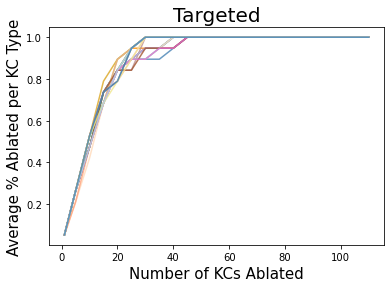

In [14]:
# find number of each type of KC in the network
list_names = list(kc_mbon.index)
type_counts = np.zeros(7)
for t in range(7):
    type_counts[t] = list_names.count(kc_types[t])
print(type_counts)
    
# x-axis -> number of KCs removed
x = np.ones(23)
x[1:] = np.linspace(5, 110, 22)
x = x.astype(int)

# format names
for r in range(R):
    for a in range(len(kc_names)):
        sub_list = kc_names[a][r] # r = realization
        for b in range(len(sub_list)):
            s = sub_list[b]
            idx = s.index('t') + 1 # index after t in "left"
            kc_names[a][r][b] = s[0:idx]

# y-axis -> percentage of each type out of the total number of kcs ablated
y = np.zeros((R, K)) 
for r in range(R):
    for k in range(K):
        names = kc_names[k][r] # the k removed KCs, for realization r
        y[r, k] = names.count(kc_types[0]) / float(type_counts[0])

# plot
plt.figure()
for r in range(R):
    plt.plot(x, y[r], alpha=0.8)
plt.title("Targeted", fontsize=title_fontsize)    
plt.xlabel("Number of KCs Ablated", fontsize=axis_fontsize)
plt.ylabel("Average % Ablated per KC Type", fontsize=axis_fontsize)

# Figure 5 - Pruning Cartoon

Text(0.5, 1.0, 'Targeted Pruning')

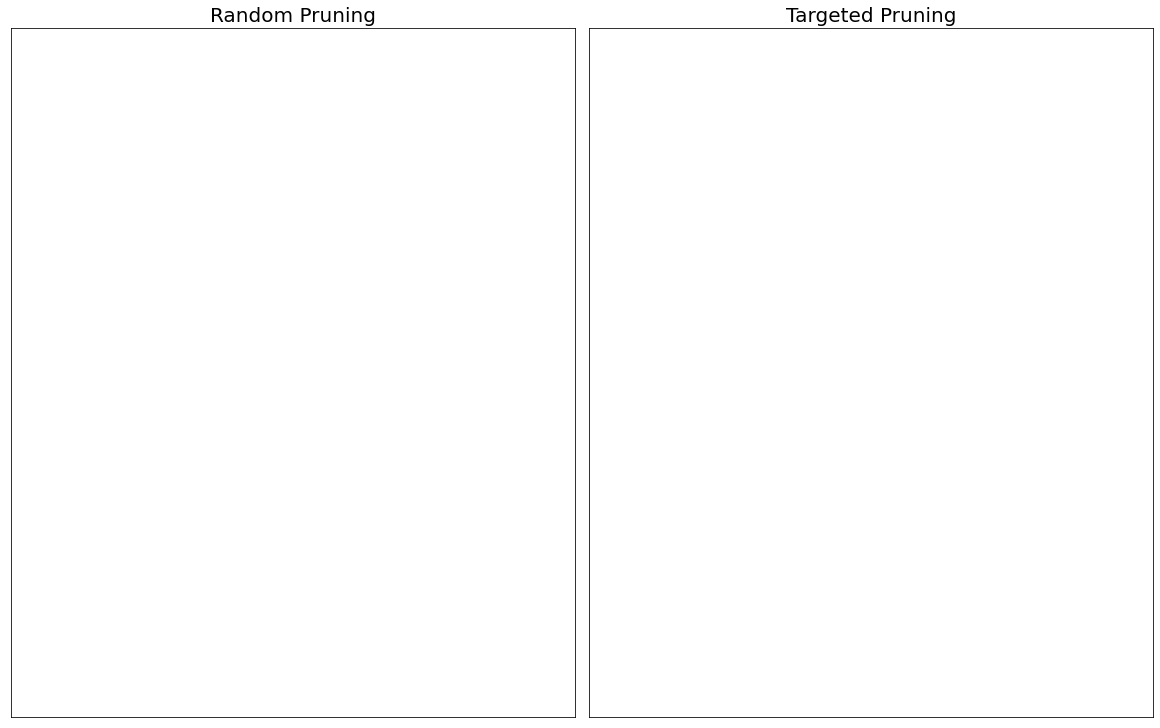

In [73]:
axis_fontsize = 15
title_fontsize = 20
legend_fontsize = 8
fig5 = plt.figure(figsize=(16,10), constrained_layout=True)
gs5 = fig5.add_gridspec(ncols=6, nrows=6)

# 3A CARTOON OF RANDOM ABLATION
f5_ax1 = fig5.add_subplot(gs5[0:6, 0:3])

# remove x and y ticks
# x axis
f5_ax1.set_xticklabels([])
f5_ax1.set_xticks([])

# y axis
f5_ax1.set_yticklabels([])
f5_ax1.set_yticks([])

f5_ax1.set_title("Random Pruning", fontsize=title_fontsize)

# 3B CARTOON OF TARGETED ABLATION
f5_ax2 = fig5.add_subplot(gs5[0:6, 3:])

# remove x and y ticks
# x axis
f5_ax2.set_xticklabels([])
f5_ax2.set_xticks([])

# y axis
f5_ax2.set_yticklabels([])
f5_ax2.set_yticks([])

f5_ax2.set_title("Targeted Pruning", fontsize=title_fontsize)

# Figure 6 - Pruning Results

Text(0, 0.5, 'Average % Pruned per KC Type')

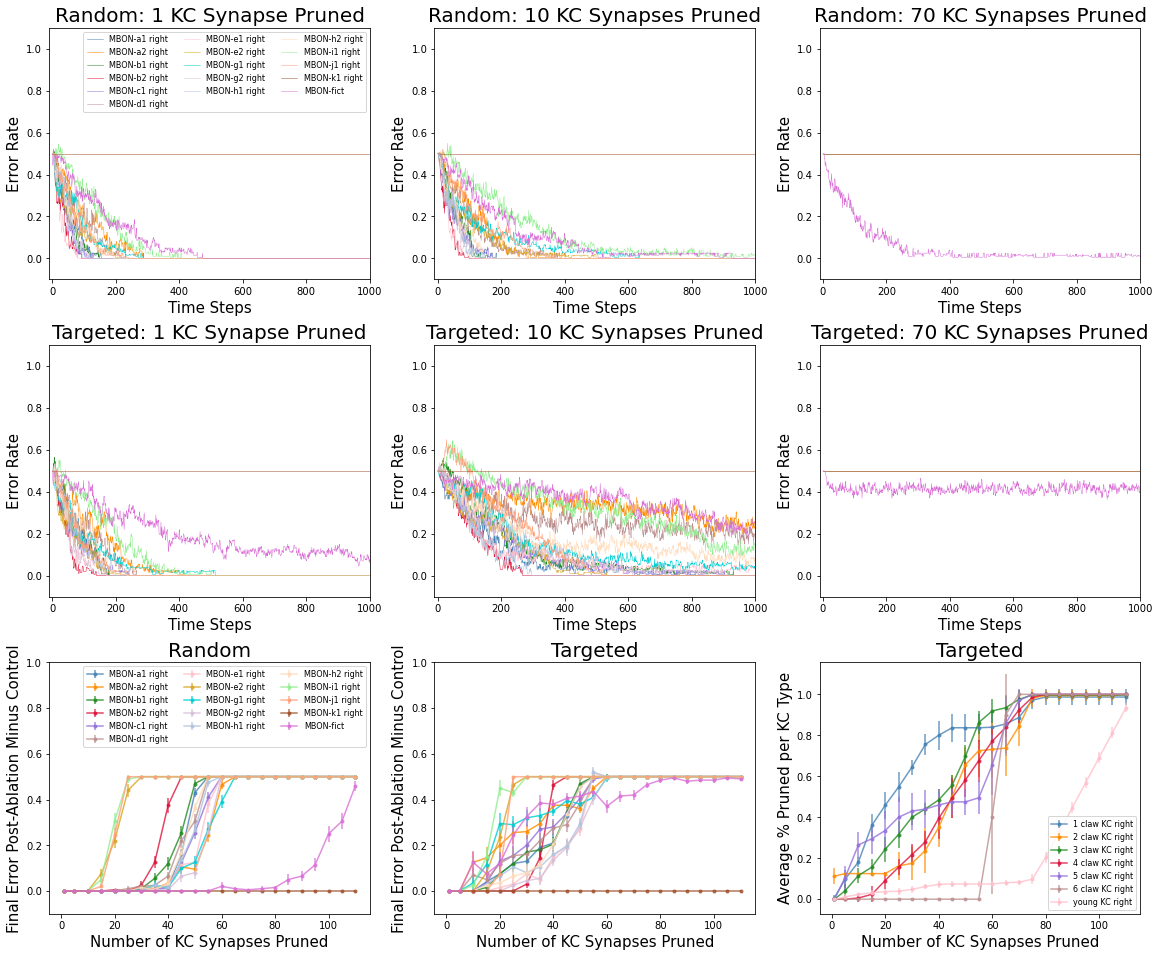

In [15]:
axis_fontsize = 15
title_fontsize = 20
legend_fontsize = 8
fig6 = plt.figure(figsize=(16,30), constrained_layout=True)
gs6 = fig6.add_gridspec(ncols=6, nrows=15)

# 6A ERROR OVER TIME (REMOVED 1) - RANDOM
f6_ax1 = fig6.add_subplot(gs6[6:8, 0:2])

# list of num of KCs removed
num_removed = np.ones(24)
num_removed[1:23] = np.linspace(5, 110, 22)
num_removed[23] = 113
num_removed = num_removed.astype(int)

# import data
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-pruning2/all-error-rates4.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-pruning3/all-error-rates4.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f) 

# concatenate arrays from both runs
r_error_rate_over_time = np.concatenate((error_over_time1, error_over_time2), axis = 1)


avg_error = np.mean(r_error_rate_over_time, axis=1)

x = np.linspace(0, 5000, 5000)

for i in range(num_mbons):
    f6_ax1.plot(x, avg_error[0, : ,i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f6_ax1.set_ylim(-0.1, 1.1)
f6_ax1.set_xlim(-10, 1000)
f6_ax1.legend(fontsize=legend_fontsize, loc=1, ncol=3)
f6_ax1.set_title("Random: {} KC Synapse Pruned".format(num_removed[0]), fontsize=title_fontsize)
f6_ax1.set_xlabel("Time Steps", fontsize=axis_fontsize)
f6_ax1.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 6B ERROR OVER TIME (REMOVED 10) - RANDOM
f6_ax2 = fig6.add_subplot(gs6[6:8, 2:4])

for i in range(num_mbons):
    f6_ax2.plot(x, avg_error[2, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f6_ax2.set_ylim(-0.1, 1.1)
f6_ax2.set_xlim(-10, 1000)
f6_ax2.set_title("Random: {} KC Synapses Pruned".format(num_removed[2]), fontsize=title_fontsize)
f6_ax2.set_xlabel("Time Steps", fontsize=axis_fontsize)
f6_ax2.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 6C ERROR OVER TIME (REMOVED 70) - RANDOM
f6_ax3 = fig6.add_subplot(gs6[6:8, 4:])

for i in range(num_mbons):
    f6_ax3.plot(x, avg_error[14, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f6_ax3.set_ylim(-0.1, 1.1)
f6_ax3.set_xlim(-10, 1000)
f6_ax3.set_title("Random: {} KC Synapses Pruned".format(num_removed[14]), fontsize=title_fontsize)
f6_ax3.set_xlabel("Time Steps", fontsize=axis_fontsize)
f6_ax3.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 6D ERROR OVER TIME (REMOVED 1) - TARGETED
f6_ax4 = fig6.add_subplot(gs6[8:10, 0:2])
    
# import data
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-pruning2/all-error-rates5.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-pruning3/all-error-rates5.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f)
    
t_error_rate_over_time = np.concatenate((error_over_time1, error_over_time2), axis = 1)

avg_error = np.mean(t_error_rate_over_time, axis=1)

x = np.linspace(0, 5000, 5000)

for i in range(num_mbons):
    f6_ax4.plot(x, avg_error[0, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f6_ax4.set_ylim(-0.1, 1.1)
f6_ax4.set_xlim(-10, 1000)
f6_ax4.set_title("Targeted: {} KC Synapse Pruned".format(num_removed[0]), fontsize=title_fontsize)
f6_ax4.set_xlabel("Time Steps", fontsize=axis_fontsize)
f6_ax4.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 6E ERROR OVER TIME (REMOVED 10) - TARGETED
f6_ax5 = fig6.add_subplot(gs6[8:10, 2:4])

for i in range(num_mbons):
    f6_ax5.plot(x, avg_error[2, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f6_ax5.set_ylim(-0.1, 1.1)
f6_ax5.set_xlim(-10, 1000)
f6_ax5.set_title("Targeted: {} KC Synapses Pruned".format(num_removed[2]), fontsize=title_fontsize)
f6_ax5.set_xlabel("Time Steps", fontsize=axis_fontsize)
f6_ax5.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 6F ERROR OVER TIME (REMOVED 70) - TARGETED
f6_ax6 = fig6.add_subplot(gs6[8:10, 4:])

for i in range(num_mbons):
    f6_ax6.plot(x, avg_error[14, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f6_ax6.set_ylim(-0.1, 1.1)
f6_ax6.set_xlim(-10, 1000)
f6_ax6.set_title("Targeted: {} KC Synapses Pruned".format(num_removed[14]), fontsize=title_fontsize)
f6_ax6.set_xlabel("Time Steps", fontsize=axis_fontsize)
f6_ax6.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 6G ERROR VS NUM KCS ABLATED - RANDOM
f6_ax7 = fig6.add_subplot(gs6[10:12, 0:2])

# import data
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control2/all-error-rates1.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # R, T, num_mbons

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control3/all-error-rates1.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f)

# concatenate arrays from both runs
error_control = np.concatenate((error_over_time1, error_over_time2), axis = 0)

# x-axis -> number of KCs removed
numbers = np.ones(24)
numbers[1:23] = np.linspace(5, 110, 22)
numbers[23] = 113
numbers = numbers.astype(int).tolist()
x = []       
for i in range(num_mbons):
    for j in range(K):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(r_error_rate_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
for i in range(K):
#     std_y[i] = np.std(r_error_rate_over_time[i], axis=0)
    std_y[i] = st.sem(r_error_rate_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
    f6_ax7.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.8, 
                    label=kc_mbon.columns[p], ms=3, c=colors[p])

f6_ax7.set_xlabel("Number of KC Synapses Pruned", fontsize=axis_fontsize)
f6_ax7.set_ylabel("Final Error Post-Ablation Minus Control", fontsize=axis_fontsize)
f6_ax7.set_ylim(-0.1, 1.0)
f6_ax7.set_title("Random", fontsize=title_fontsize)
f6_ax7.legend(fontsize=legend_fontsize, loc=1, ncol=3)

# 6H ERROR VS NUM KCS ABLATED - TARGETED
f6_ax8 = fig6.add_subplot(gs6[10:12, 2:4])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(t_error_rate_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
for i in range(K):
#     std_y[i] = np.std(t_error_rate_over_time[i], axis=0)
    std_y[i] = st.sem(t_error_rate_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
    f6_ax8.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.8, 
                     label=kc_mbon.columns[p], ms=3, c=colors[p])

f6_ax8.set_xlabel("Number of KC Synapses Pruned", fontsize=axis_fontsize)
f6_ax8.set_ylabel("Final Error Post-Ablation Minus Control", fontsize=axis_fontsize)
f6_ax8.set_ylim(-0.1, 1.0)
f6_ax8.set_title("Targeted", fontsize=title_fontsize)

# 6I AVERAGE PERCENTAGE PRUNED OF EACH TYPE VS NUMBER OF KC SYNAPSES PRUNED
f6_ax9 = fig6.add_subplot(gs6[10:12, 4:6])

# import data
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-pruning2/kcs-removed5.pkl', 'rb') as f:
    kc_names1 = pickle.load(f) # K, R, index of a KC removed

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-pruning3/kcs-removed5.pkl', 'rb') as f:
    kc_names2 = pickle.load(f) # K, R, index of a KC removed

kc_names1 = np.array(kc_names1, dtype='object')
kc_names2 = np.array(kc_names2, dtype='object')

kc_names = np.concatenate((kc_names1, kc_names2), axis = 1)
        
# x-axis -> number of KCs removed
x = np.ones(23)
x[1:] = np.linspace(5, 110, 22)
x = x.astype(int)

# format names
for r in range(R):
    for a in range(len(kc_names)):
        sub_list = kc_names[a][r] # r = realization
        for b in range(len(sub_list)):
            s = sub_list[b]
            idx = s.index('t') + 1 # index after t in "left"
            kc_names[a][r][b] = s[0:idx]

# y-axis -> percentage of each type out of the total number of kcs ablated
y = np.zeros((R, 7, K)) # 7 = number of KC types
for r in range(R):
    for k in range(K):
        names = kc_names[k][r] # the k removed KCs, for realization r
        for t in range(7):
            y[r, t, k] = names.count(kc_types[t]) / float(type_counts[t])
            
# plot averaged plot over the 10 realizations
# calculate average percentages across realizations
y_avg = np.mean(y, axis=0)

# calculate std of percentages across realizations
y_std = np.std(y, axis=0)

# plot
for t in range(7):
    f6_ax9.errorbar(x, y_avg[t], yerr=y_std[t], alpha=0.8, marker='.', label=kc_types[t], c=colors[t])
f6_ax9.set_title("Targeted", fontsize=title_fontsize)    
f6_ax9.legend(fontsize=legend_fontsize, loc=4)
f6_ax9.set_xlabel("Number of KC Synapses Pruned", fontsize=axis_fontsize)
f6_ax9.set_ylabel("Average % Pruned per KC Type", fontsize=axis_fontsize)

# Figure 7 - Comparison (Pruning and Ablation)

Text(0.5, 1.0, 'Targeted')

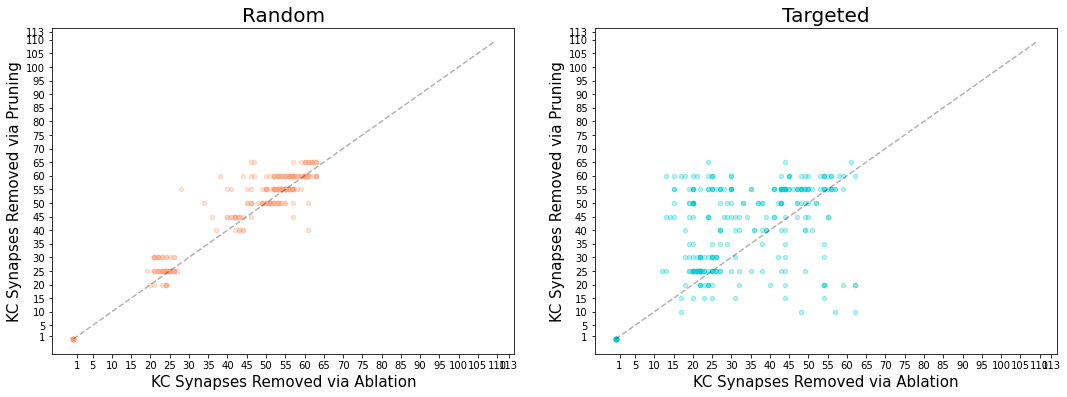

In [9]:
axis_fontsize = 15
title_fontsize = 20
legend_fontsize = 12
fig7 = plt.figure(figsize=(18,6), constrained_layout=False)
gs7 = fig7.add_gridspec(ncols=6, nrows=2)

gs7.update(wspace=0.8, hspace=0.4) # set the spacing between axes

# NUMBER PRUNED VS ABLATED 
# 7A RANDOM (ER = 0.5)
f7_ax1 = fig7.add_subplot(gs7[0:2, 0:3])

# excluding the fictional MBON, there are 18 MBONs
num_mbons = 15

# import data
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control2/all-error-rates1.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # R, T, num_mbons

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control3/all-error-rates1.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f)

# concatenate arrays from both runs
error_control_p = np.concatenate((error_over_time1, error_over_time2), axis = 0)
error_control_a = error_control_p
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-pruning2/all-error-rates4.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # dimensions: K, R, T, num_mbons

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-pruning3/all-error-rates4.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f) # K, R, T, num_mbons

# concatenate
error_over_time_p = np.concatenate((error_over_time1, error_over_time2), axis = 1)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-ablation2/all-error-rates2.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-ablation3/all-error-rates2.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f) 

# concatenate arrays 
error_over_time_a = np.concatenate((error_over_time1, error_over_time2), axis = 1)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-ablation2/kcs-removed2.pkl', 'rb') as f:
    kc_names1 = pickle.load(f) # K, R, index of a KC removed

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-ablation3/kcs-removed2.pkl', 'rb') as f:
    kc_names2 = pickle.load(f) # K, R, index of a KC removed

kc_names1 = np.array(kc_names1, dtype='object')
kc_names2 = np.array(kc_names2, dtype='object')

kcs_removed = np.concatenate((kc_names1, kc_names2), axis = 1)

# record x and y coordinates from every realization
x_total = np.zeros((R, num_mbons))
y_total = np.zeros((R, num_mbons))

# number of KCs supposedly to be removed
numbers = np.ones(24)
numbers[1:23] = np.linspace(5, 110, 22)
numbers[23] = 113
numbers = numbers.astype(int).tolist()

for r in range(R):

    # PRUNING
    # x-axis -> number of KCs removed 
    x_p = []

    for i in range(num_mbons):
        for j in range(K):
            x_p.append(numbers[j])

    # y-axis - final error rate for realization r
    y_p = []
    for k in range(num_mbons):
        for i in range(K):
            y_p.append(error_over_time_p[i,r,-1,k] - error_control_p[r,-1,k]) # exclude fictional MBON (will skew results)


    # ABLATION
    # gets number of presynaptic KCs for each MBON
    bool_synapses = np.where(kc_mbon > 0, 1, 0)
    conn = np.zeros(num_mbons)
    for j in range(num_mbons):
        conn[j] = bool_synapses[:,j].sum()
    conn = conn.astype(int) # number of connections to KCs for each MBON

    # x-axis -> number of KCs removed
    x_a = []

    # x-axis calculations - calculates the actual number of synapses removed
    for i in range(num_mbons):
        for j in range(K):
            n = numbers[j] # num kcs ablated
            l = kcs_removed[j][r] # list of kcs removed for realization r
            l_num = get_num_kc(l, n) # converts list of names to numbers

            num_removed = count_num_removed(kc_mbon, l_num, i) # number of kc connections removed from this MBON
            x_a.append(num_removed)    

    # y-axis - final error rate for realization r
    y_a = []
    for m in range(num_mbons):
        for k in range(K):
            y_a.append(error_over_time_a[k, r, -1, m] - error_control_a[r, -1, m]) # excludes fict. MBON (skews results)

    # SUMMARY
    # Get the x and y coordinates for summary plot
    x_p = np.asarray(x_p).reshape(num_mbons, K)
    y_p = np.asarray(y_p).reshape(num_mbons, K)

    x_a = np.asarray(x_a).reshape(num_mbons, K)
    y_a = np.asarray(y_a).reshape(num_mbons, K)

    x = np.zeros(num_mbons) # ablation
    y = np.zeros(num_mbons) # pruning

    for m in range(num_mbons):
        num_removed_x = 0
        # ablation
        found_a = False
        k_a = 0 # move through the columns
        while (not found_a) and (k_a < K):
            if y_a[m, k_a] > 0.45:
                x[m] = x_a[m, k_a]
                found_a = True
            k_a += 1

        # pruning
        found_p = False
        k_p = 0 # move through the columns
        while (not found_p) and (k_p < K):
            # ablation
            if y_p[m, k_p] > 0.45:
                y[m] = x_p[m, k_p]
                found_p = True
            k_p += 1 

    x_total[r] = x
    y_total[r] = y
    
# plot
for r in range(R):
    for m in range(num_mbons):
        f7_ax1.scatter(x_total[r, m], y_total[r, m], alpha=0.3, color=colors[13], s=20)
#         f7_ax1.text(x_total[r, m], y_total[r, m], s=kc_mbon.columns[m])
f7_ax1.plot(np.arange(110), np.arange(110), alpha=0.3, linestyle='dashed', color='black')
f7_ax1.set_xlabel("KC Synapses Removed via Ablation", fontsize=axis_fontsize)
f7_ax1.set_ylabel("KC Synapses Removed via Pruning", fontsize=axis_fontsize)
f7_ax1.set_xticks(numbers)
f7_ax1.set_yticks(numbers)
f7_ax1.set_title("Random", fontsize=title_fontsize)

# 7B TARGETED (ER = 0.5)
f7_ax2 = fig7.add_subplot(gs7[0:2, 3:6])

# import data  
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control2/all-error-rates1.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # R, T, num_mbons

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control3/all-error-rates1.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f)

# concatenate arrays from both runs
error_control_p = np.concatenate((error_over_time1, error_over_time2), axis = 0)
error_control_a = error_control_p
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-pruning2/all-error-rates5.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # dimensions: K, R, T, num_mbons

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-pruning3/all-error-rates5.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f) # K, R, T, num_mbons

# concatenate
error_over_time_p = np.concatenate((error_over_time1, error_over_time2), axis = 1)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-ablation2/all-error-rates3.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-ablation3/all-error-rates3.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f) 

# concatenate arrays 
error_over_time_a = np.concatenate((error_over_time1, error_over_time2), axis = 1)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-ablation2/kcs-removed3.pkl', 'rb') as f:
    kc_names1 = pickle.load(f) # K, R, index of a KC removed

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-ablation3/kcs-removed3.pkl', 'rb') as f:
    kc_names2 = pickle.load(f) # K, R, index of a KC removed

kc_names1 = np.array(kc_names1, dtype='object')
kc_names2 = np.array(kc_names2, dtype='object')

kcs_removed = np.concatenate((kc_names1, kc_names2), axis = 1)

# record x and y coordinates from every realization
x_total = np.zeros((R, num_mbons))
y_total = np.zeros((R, num_mbons))

# number of KCs supposedly to be removed
numbers = np.ones(24)
numbers[1:23] = np.linspace(5, 110, 22)
numbers[23] = 113
numbers = numbers.astype(int).tolist()

for r in range(R):

    # PRUNING
    # x-axis -> number of KCs removed 
    x_p = []

    for i in range(num_mbons):
        for j in range(K):
            x_p.append(numbers[j])

    # y-axis - final error rate for realization r
    y_p = []
    for k in range(num_mbons):
        for i in range(K):
            y_p.append(error_over_time_p[i,r,-1,k] - error_control_p[r,-1,k]) # exclude fictional MBON (will skew results)


    # ABLATION
    # gets number of presynaptic KCs for each MBON
    bool_synapses = np.where(kc_mbon > 0, 1, 0)
    conn = np.zeros(num_mbons)
    for j in range(num_mbons):
        conn[j] = bool_synapses[:,j].sum()
    conn = conn.astype(int) # number of connections to KCs for each MBON

    # x-axis -> number of KCs removed
    x_a = []

    # x-axis calculations - calculates the actual number of synapses removed
    for i in range(num_mbons):
        for j in range(K):
            n = numbers[j] # num kcs ablated
            l = kcs_removed[j][r] # list of kcs removed for realization r
            l_num = get_num_kc(l, n) # converts list of names to numbers

            num_removed = count_num_removed(kc_mbon, l_num, i) # number of kc connections removed from this MBON
            x_a.append(num_removed)    

    # y-axis - final error rate for realization r
    y_a = []
    for m in range(num_mbons):
        for k in range(K):
            y_a.append(error_over_time_a[k, r, -1, m] - error_control_a[r, -1, m]) # excludes fict. MBON (skews results)

    # SUMMARY
    # Get the x and y coordinates for summary plot
    x_p = np.asarray(x_p).reshape(num_mbons, K)
    y_p = np.asarray(y_p).reshape(num_mbons, K)

    x_a = np.asarray(x_a).reshape(num_mbons, K)
    y_a = np.asarray(y_a).reshape(num_mbons, K)

    x = np.zeros(num_mbons) # ablation
    y = np.zeros(num_mbons) # pruning

    for m in range(num_mbons):
        num_removed_x = 0
        # ablation
        found_a = False
        k_a = 0 # move through the columns
        while (not found_a) and (k_a < K):
            if y_a[m, k_a] >= 0.5:
                x[m] = x_a[m, k_a]
                found_a = True
            k_a += 1

        # pruning
        found_p = False
        k_p = 0 # move through the columns
        while (not found_p) and (k_p < K):
            # ablation
            if y_p[m, k_p] >= 0.5:
                y[m] = x_p[m, k_p]
                found_p = True
            k_p += 1 

    x_total[r] = x
    y_total[r] = y
    
# plot
for r in range(R):
    for m in range(num_mbons):
        f7_ax2.scatter(x_total[r, m], y_total[r, m], alpha=0.3, color=colors[8], s=20)
f7_ax2.plot(np.arange(110), np.arange(110), alpha=0.3, linestyle='dashed', color='black')
f7_ax2.set_xlabel("KC Synapses Removed via Ablation", fontsize=axis_fontsize)
f7_ax2.set_ylabel("KC Synapses Removed via Pruning", fontsize=axis_fontsize)
f7_ax2.set_xticks(numbers)
f7_ax2.set_yticks(numbers)
f7_ax2.set_title("Targeted", fontsize=title_fontsize)

In [36]:
string = ""
for m in range(num_mbons):
    string += str(m) + ". " + kc_mbon.columns[m] + " "
print(string)
for r in range(R):
    print("Ablation:", x_total[r])
    print("Pruning:", y_total[r])
    print()

0. MBON-a1 right 1. MBON-a2 right 2. MBON-b1 right 3. MBON-b2 right 4. MBON-c1 right 5. MBON-d1 right 6. MBON-e1 right 7. MBON-e2 right 8. MBON-g1 right 9. MBON-g2 right 10. MBON-h1 right 11. MBON-h2 right 12. MBON-i1 right 13. MBON-j1 right 14. MBON-k1 right 
Ablation: [50. 60. 51. 43. 57. 54. 57. 25. 47. 60. 56. 53. 21. 26.  0.]
Pruning: [50. 60. 50. 45. 55. 55. 60. 25. 65. 60. 55. 55. 20. 25.  0.]

Ablation: [53. 61. 51. 43. 57. 54. 56. 24. 62. 60. 56. 54. 21. 26.  0.]
Pruning: [55. 60. 55. 45. 55. 55. 55. 20. 65. 60. 60. 55. 30. 25.  0.]

Ablation: [53. 60. 50. 40. 51. 53.  0. 25. 54. 59.  0.  0. 23. 24.  0.]
Pruning: [55. 60. 55. 45. 60. 55. 55. 25. 55. 60. 45. 55. 25. 25.  0.]

Ablation: [ 0. 62. 40. 43. 57. 54. 56. 25. 53. 60. 56. 50. 27. 24.  0.]
Pruning: [55. 60. 55. 40. 60. 55. 55. 25. 60. 60. 55. 55. 25. 25.  0.]

Ablation: [50. 46. 50. 42. 56.  0. 55. 24. 47. 59. 38. 52. 21. 19.  0.]
Pruning: [50. 65. 50. 45. 60. 55. 55. 25. 60. 55. 60. 55. 30. 25.  0.]

Ablation: [53. 61. 

## Slope vs. Error Rate

In [12]:
axis_fontsize = 15
title_fontsize = 20
legend_fontsize = 8
num_mbons = 15 # exclude fict MBON

# RANDOM
# import data 
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control2/all-error-rates1.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # R, T, num_mbons

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control3/all-error-rates1.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f)

# concatenate arrays from both runs
error_control_p = np.concatenate((error_over_time1, error_over_time2), axis = 0)
error_control_a = error_control_p
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-pruning2/all-error-rates4.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # dimensions: K, R, T, num_mbons

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-pruning3/all-error-rates4.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f) # K, R, T, num_mbons

# concatenate
error_over_time_p = np.concatenate((error_over_time1, error_over_time2), axis = 1)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-ablation2/all-error-rates2.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-ablation3/all-error-rates2.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f) 

# concatenate arrays 
error_over_time_a = np.concatenate((error_over_time1, error_over_time2), axis = 1)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-ablation2/kcs-removed2.pkl', 'rb') as f:
    kc_names1 = pickle.load(f) # K, R, index of a KC removed

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/random-ablation3/kcs-removed2.pkl', 'rb') as f:
    kc_names2 = pickle.load(f) # K, R, index of a KC removed

kc_names1 = np.array(kc_names1, dtype='object')
kc_names2 = np.array(kc_names2, dtype='object')

kcs_removed = np.concatenate((kc_names1, kc_names2), axis = 1)

# number of KCs supposedly to be removed
numbers = np.ones(24)
numbers[1:23] = np.linspace(5, 110, 22)
numbers[23] = 113
numbers = numbers.astype(int).tolist()

E = 10 # number of error rate thresholds
rates = np.linspace(0.05, 0.5, num=10) # error rates from 0 to 0.5
all_avg_slopes_r = np.zeros(E)
all_sem_slopes_r = np.zeros(E)

# record x and y coordinates from every realization
x_total_r = np.zeros((R, num_mbons))
y_total_r = np.zeros((R, num_mbons))

for e in range(E):
    for r in range(R):
        # PRUNING
        x_p = [] # number of KC synapses removed 
        y_p = [] # final error rate for realization r

        for m in range(num_mbons):
            for k in range(K):
                x_p.append(numbers[k])
                y_p.append(error_over_time_p[k,r,-1,m]) # exclude fictional MBON (will skew results)
                
        # reshape
        x_p = np.asarray(x_p).reshape(num_mbons, K)
        y_p = np.asarray(y_p).reshape(num_mbons, K)

        # ABLATION
        # gets number of presynaptic KCs for each MBON
        bool_synapses = np.where(kc_mbon > 0, 1, 0)
        conn = np.zeros(num_mbons)
        for j in range(num_mbons):
            conn[j] = bool_synapses[:,j].sum()
        conn = conn.astype(int) # number of connections to each MBON

        x_a = [] # calculates the actual number of synapses removed after ablation
        y_a = [] # final error rate for realization r

        for m in range(num_mbons):
            for k in range(K):
                n = numbers[k] # num kcs ablated
                l = kcs_removed[k][0] # list of kcs removed for realization 1
                l_num = get_num_kc(l, n) # converts list of names to numbers

                num_removed = count_num_removed(kc_mbon, l_num, m) # number of kc connections removed from this MBON
                x_a.append(num_removed)    

                y_a.append(error_over_time_a[k, r, -1, m]) # excludes fict. MBON (skews results)
        
        # reshape
        x_a = np.asarray(x_a).reshape(num_mbons, K)
        y_a = np.asarray(y_a).reshape(num_mbons, K)
       
        # SUMMARY

        # Get the x and y coordinates for error rate at index e
        x = np.zeros(num_mbons) # ablation
        y = np.zeros(num_mbons) # pruning

        for m in range(num_mbons):
            num_removed_x = 0
            # ablation
            found_a = False
            k_a = 0 # move through the columns
            while (not found_a) and (k_a < K):
                if y_a[m, k_a] >= rates[e]:
                    x[m] = x_a[m, k_a]
                    found_a = True
                k_a += 1

            # pruning
            found_p = False
            k_p = 0 # move through the columns
            while (not found_p) and (k_p < K):
                # ablation
                if y_p[m, k_p] >= rates[e]:
                    y[m] = x_p[m, k_p]
                    found_p = True
                k_p += 1 

        x_total_r[r] = x
        y_total_r[r] = y
        
    # calculates slope of the regression based on the regression formula equation ss
    all_slopes_r = np.zeros(R)

    for r in range(R):
        sum1 = 0
        sum2 = 0
        for m in range(num_mbons):
            sum1 += x_total_r[r, m] * y_total_r[r, m]
            sum2 += x_total_r[r, m] ** 2
        all_slopes_r[r] = sum1 / sum2

    all_avg_slopes_r[e] = np.mean(all_slopes_r)
    all_sem_slopes_r[e] = st.sem(all_slopes_r)
        
# TARGETED
# import data 
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control2/all-error-rates1.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # R, T, num_mbons

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/control3/all-error-rates1.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f)

# concatenate arrays from both runs
error_control_p = np.concatenate((error_over_time1, error_over_time2), axis = 0)
error_control_a = error_control_p
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-pruning2/all-error-rates5.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # dimensions: K, R, T, num_mbons

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-pruning3/all-error-rates5.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f) # K, R, T, num_mbons

# concatenate
error_over_time_p = np.concatenate((error_over_time1, error_over_time2), axis = 1)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-ablation2/all-error-rates3.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f) # K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-ablation3/all-error-rates3.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f) 

# concatenate arrays 
error_over_time_a = np.concatenate((error_over_time1, error_over_time2), axis = 1)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-ablation2/kcs-removed3.pkl', 'rb') as f:
    kc_names1 = pickle.load(f) # K, R, index of a KC removed

with open('C:/Katherine/Research/experiment-data-v3/10-odors-right/targeted-ablation3/kcs-removed3.pkl', 'rb') as f:
    kc_names2 = pickle.load(f) # K, R, index of a KC removed

kc_names1 = np.array(kc_names1, dtype='object')
kc_names2 = np.array(kc_names2, dtype='object')

kcs_removed = np.concatenate((kc_names1, kc_names2), axis = 1)

# record regression slopes
all_avg_slopes_t = np.zeros(E)
all_sem_slopes_t = np.zeros(E)

# record x and y coordinates from every realization
x_total_t = np.zeros((R, num_mbons))
y_total_t = np.zeros((R, num_mbons))

for e in range(E):
    for r in range(R):
        # PRUNING
        x_p = [] # number of KC synapses removed 
        y_p = [] # final error rate for realization r

        for m in range(num_mbons):
            for k in range(K):
                x_p.append(numbers[k])
                y_p.append(error_over_time_p[k,r,-1,m]) # exclude fictional MBON (will skew results)
                
        # reshape
        x_p = np.asarray(x_p).reshape(num_mbons, K)
        y_p = np.asarray(y_p).reshape(num_mbons, K)

        # ABLATION
        # gets number of presynaptic KCs for each MBON
        bool_synapses = np.where(kc_mbon > 0, 1, 0)
        conn = np.zeros(num_mbons)
        for j in range(num_mbons):
            conn[j] = bool_synapses[:,j].sum()
        conn = conn.astype(int) # number of connections to each MBON

        x_a = [] # calculates the actual number of synapses removed after ablation
        y_a = [] # final error rate for realization r

        for m in range(num_mbons):
            for k in range(K):
                n = numbers[k] # num kcs ablated
                l = kcs_removed[k][0] # list of kcs removed for realization 1
                l_num = get_num_kc(l, n) # converts list of names to numbers

                num_removed = count_num_removed(kc_mbon, l_num, m) # number of kc connections removed from this MBON
                x_a.append(num_removed)    

                y_a.append(error_over_time_a[k, r, -1, m]) # excludes fict. MBON (skews results)
        
        # reshape
        x_a = np.asarray(x_a).reshape(num_mbons, K)
        y_a = np.asarray(y_a).reshape(num_mbons, K)
       
        # SUMMARY

        # Get the x and y coordinates for error rate at index e
        x = np.zeros(num_mbons) # ablation
        y = np.zeros(num_mbons) # pruning

        for m in range(num_mbons):
            num_removed_x = 0
            # ablation
            found_a = False
            k_a = 0 # move through the columns
            while (not found_a) and (k_a < K):
                if y_a[m, k_a] >= rates[e]:
                    x[m] = x_a[m, k_a]
                    found_a = True
                k_a += 1

            # pruning
            found_p = False
            k_p = 0 # move through the columns
            while (not found_p) and (k_p < K):
                # ablation
                if y_p[m, k_p] >= rates[e]:
                    y[m] = x_p[m, k_p]
                    found_p = True
                k_p += 1 

        x_total_t[r] = x
        y_total_t[r] = y
        
    # calculates slope of the regression based on the regression formula equation ss
    all_slopes_t = np.zeros(R)

    for r in range(R):
        sum1 = 0
        sum2 = 0
        for m in range(num_mbons):
            sum1 += x_total_t[r, m] * y_total_t[r, m]
            sum2 += x_total_t[r, m] ** 2
        all_slopes_t[r] = sum1 / sum2

    all_avg_slopes_t[e] = np.mean(all_slopes_t)
    all_sem_slopes_t[e] = st.sem(all_slopes_t)

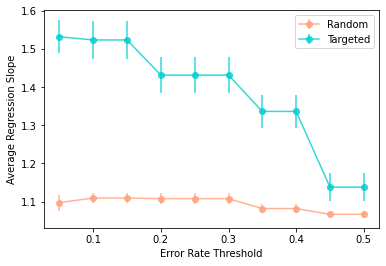

In [13]:
# plot average slopes vs error rates with standard error bars
plot_data_r = pd.DataFrame({'ER':rates, 'Slope':all_avg_slopes_r, 'SEM':all_sem_slopes_r})
plot_data_t = pd.DataFrame({'ER':rates, 'Slope':all_avg_slopes_t, 'SEM':all_sem_slopes_t})

plt.figure()

plt.errorbar(x=plot_data_r['ER'], y=plot_data_r['Slope'], yerr=plot_data_r['SEM'], fmt="o", ls='solid', 
             alpha = 0.8, c=colors[13], label='Random')
plt.errorbar(x=plot_data_t['ER'], y=plot_data_t['Slope'], yerr=plot_data_t['SEM'], fmt="o", ls='solid', 
             alpha = 0.8, c=colors[8], label='Targeted')
plt.xlabel("Error Rate Threshold")
plt.ylabel("Average Regression Slope")
plt.legend()
plt.show()